In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

from pyDOE import *
import gpflow as gp
from scipy.spatial import distance_matrix

plt.style.use('seaborn-darkgrid')
#sns.set()
sns.set_context("talk")
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from enkf.utils import *

In [3]:
from enkf.enki import *

#  Problem setup 

In [4]:
#  Problem setup 
n_obs = 2      # Data observations. Dimension of G(u)
gamma = 0.1
Gamma = gamma**2 * np.identity(n_obs)

# Generate data
y_obs = np.array([27.45194112300398, 79.70194112300398])

# Ensemble Kalman Inversion

In [5]:
J = 50          # Number of ensemble particles
p = 2           # Dimensionality of the problem.
np.random.seed(1)
Jnoise = np.linalg.cholesky(Gamma)

U0 = np.random.uniform(90,110, [p, J])
U0[0,:] = np.random.normal(0, 1.5, [p-1, J])

In [10]:
enki_elliptic = flow(p = p, n_obs = n_obs, J = J)
enki_elliptic.ustar = np.array([-2.65, 104.5])[:, np.newaxis]
enki_elliptic.mu = 0.0 * np.array([1., 1.]).reshape(2,-1)
enki_elliptic.sigma = 100.
enki_elliptic.run_nopar(y_obs, U0, elliptic, Gamma, Jnoise)

100%|██████████| 30/30 [00:00<00:00, 629.59it/s]


In [11]:
xs, ys = np.meshgrid(np.linspace(-4.6, -0.9, 60),
                   np.linspace(102.6, 106.2, 60))

Gs = enki_elliptic.Gpar(np.array([xs.flatten(), ys.flatten()]), elliptic)

Hs = ((Gs-y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs-y_obs[:,np.newaxis])).sum(axis = 0)

In [12]:
Gs.shape

(2, 3600)

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10, 10));

cmap = plt.get_cmap('gray')
#cf = plt.contourf(xs, ys, Hs.reshape(60, 60) + \
#                  ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2)), 
#                  np.percentile(Hs + ((xs.flatten()-enki_linear.mu[0])**2 + \
#                                      (ys.flatten()-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2)), range(0,101,10)), 
#                  cmap = cmap)

cf = plt.contourf(xs, ys, np.log(Hs.reshape(60, 60) + \
                ((xs-enki_elliptic.mu[0])**2 + (ys-enki_elliptic.mu[1])**2)/(2*(enki_elliptic.sigma**2))), 
                  10, 
                  cmap = cmap)


scat = []
scat.append(ax.scatter([],[], color =  u'#2ca02c')) ;

def animate(i):
    scat[0].set_offsets(np.c_[enki_elliptic.Uall[i,0,:], enki_elliptic.Uall[i,1,:]]);

plt.close()

anim = animation.FuncAnimation(fig, animate, frames = range(enki_elliptic.T))
HTML(anim.to_html5_video())

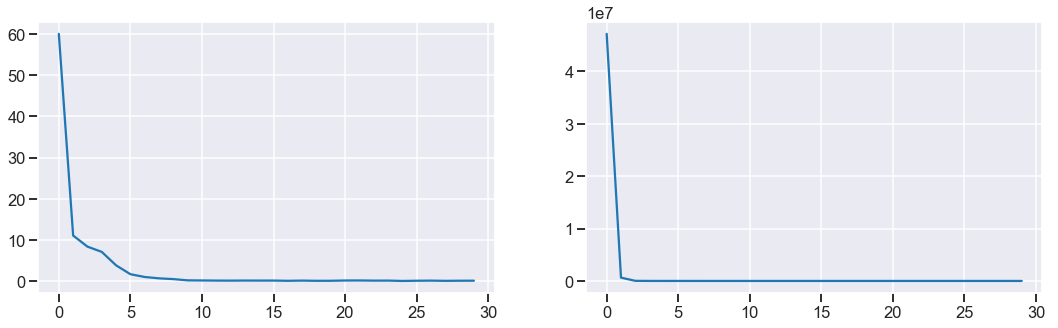

In [14]:
fig, axes = plt.subplots(1,2,figsize = (18, 5))
axes[0].plot(enki_elliptic.metrics['r'])
axes[1].plot(enki_elliptic.metrics['R'])

# GP emulation

In [9]:
enki_elliptic.emulate()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -261.674895
  Number of iterations: 38
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -261.674895
  Number of iterations: 38
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -258.544108
  Number of iterations: 45
  Number of functions evaluations: 121


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -258.544108
  Number of iterations: 45
  Number of functions evaluations: 121


In [10]:
from tqdm import tqdm

In [11]:
gplot, varplot = enki_elliptic.predict_gps(np.vstack([xs.flatten(), ys.flatten()]).T)
gstar, varstar = enki_elliptic.predict_gps(enki_elliptic.Ustar.mean(axis = 1).reshape(1, -1))

In [12]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)

In [13]:
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum()
    Hplot_semi[ii] = ((gplot[:,ii] - y_obs) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varstar.flatten())), gplot[:,ii] - y_obs)).sum()

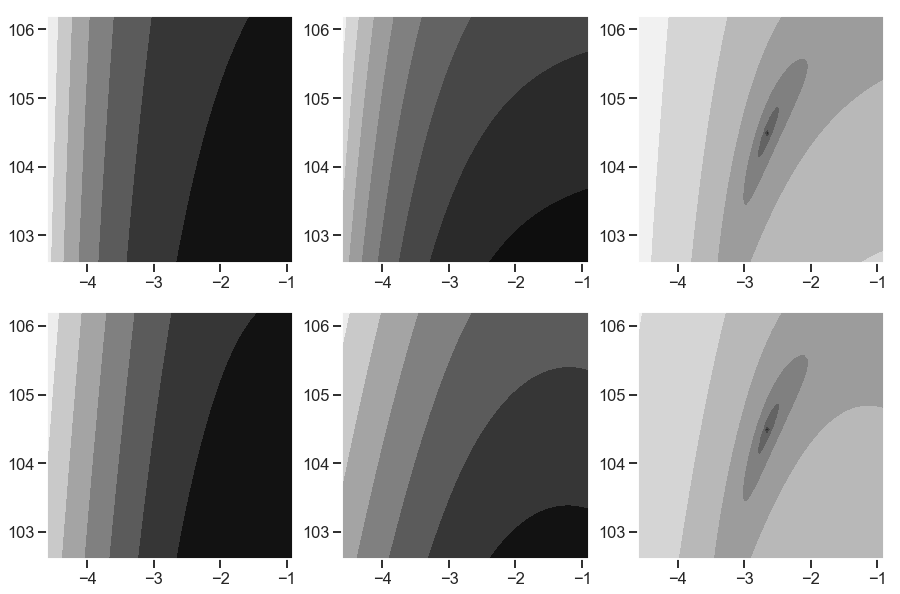

In [14]:
fig, ax = plt.subplots(2,3,figsize=(15, 10));
cmap = plt.get_cmap('gray');
ax[0,0].contourf(xs, ys, Gs[0,:].reshape(60, 60), cmap = cmap);
ax[0,1].contourf(xs, ys, Gs[1,:].reshape(60, 60), cmap = cmap);
ax[0,2].contourf(xs, ys, np.log(Hs.reshape(60, 60)), cmap = cmap);

ax[1,0].contourf(xs, ys, gplot[0,:].reshape(60, 60), cmap = cmap);
ax[1,1].contourf(xs, ys, gplot[1,:].reshape(60, 60), cmap = cmap);
ax[1,2].contourf(xs, ys, np.log(Hplot.reshape(60, 60)), cmap = cmap);

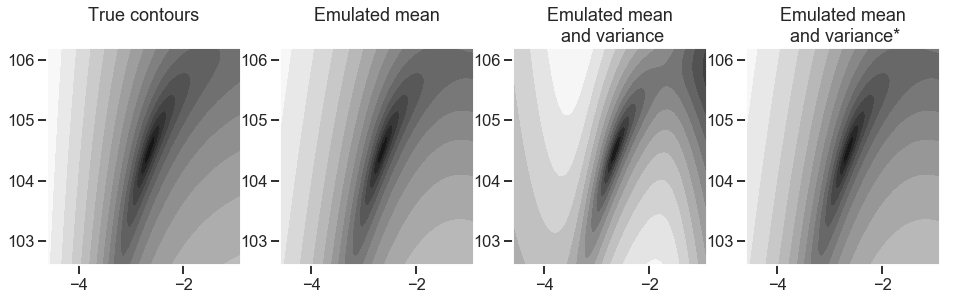

In [15]:
fig, axes = plt.subplots(1,4, figsize = (16, 4));

cmap = plt.get_cmap('gray');
axes[0].contourf(xs, ys, np.log(Hs.reshape(60, 60) + \
                  1.0 * ((xs-enki_elliptic.mu[0])**2 + (ys-enki_elliptic.mu[1])**2)/(2*(enki_elliptic.sigma**2))), 15, 
                  cmap = cmap);
axes[0].set_title('True contours\n');

axes[1].contourf(xs, ys, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((xs-enki_elliptic.mu[0])**2 + (ys-enki_elliptic.mu[1])**2)/(2*(enki_elliptic.sigma**2))), 15, 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');

axes[2].contourf(xs, ys, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((xs-enki_elliptic.mu[0])**2 + (ys-enki_elliptic.mu[1])**2)/(2*(enki_elliptic.sigma**2))), 15,
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');

axes[3].contourf(xs, ys, np.log(Hplot_semi.reshape(60, 60) + \
                  1.0 * ((xs-enki_elliptic.mu[0])**2 + (ys-enki_elliptic.mu[1])**2)/(2*(enki_elliptic.sigma**2))), 15,
                  cmap = cmap);
axes[3].set_title('Emulated mean\n and variance*');

# MCMC with independent components

In [16]:
def prior(x, mu, sigma):
    return ((x - mu)**2).sum()/(2*(sigma**2))

In [17]:
n_mcmc = 10000
scales = np.sqrt(np.diag(np.cov(enki_elliptic.Ustar)))
samples = []
current = enki_elliptic.Ustar.mean(axis = 1)
flag_noise = False

g = elliptic(current, flag_noise = flag_noise)
phi_current = ((g - y_obs) * np.linalg.solve(2 * Gamma, g - y_obs)).sum()
phi_current += prior(current, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_elliptic.p)
    
    g_proposal = elliptic(proposal, flag_noise = flag_noise)
    phi_proposal = ((g_proposal - y_obs) * np.linalg.solve(2 * Gamma, g_proposal - y_obs)).sum()
    phi_proposal += prior(proposal, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_truth = np.array(samples)

100%|██████████| 10000/10000 [00:00<00:00, 16510.36it/s]

Acceptance rate: 0.2882


In [18]:
samples_truth_clean = samples_truth.copy()

In [19]:
n_mcmc = 10000
scales = np.sqrt(np.diag(np.cov(enki_elliptic.Ustar))) * 1
samples = []
current = enki_elliptic.Ustar.mean(axis = 1)

gmean, gvars = enki_elliptic.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * Gamma, gmean - y_obs.reshape(-1,1))).sum()
phi_current += prior(current, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_elliptic.p)
    
    gmean_proposal, gvars_proposal = enki_elliptic.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * Gamma, gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += prior(proposal, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_mean = np.array(samples)

100%|██████████| 10000/10000 [00:52<00:00, 191.47it/s]

Acceptance rate: 0.3024


In [20]:
n_mcmc = 10000
scales = np.sqrt(np.diag(np.cov(enki_elliptic.Ustar))) * 1
samples = []
current = enki_elliptic.Ustar.mean(axis = 1)

gmean, gvars = enki_elliptic.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * ((1-flag_noise) * Gamma + np.diag(gvars.flatten())),
                                                               gmean - y_obs.reshape(-1,1))).sum()
phi_current += np.log((1-flag_noise) * np.diag(Gamma) + gvars.flatten()).sum()/2
phi_current += prior(current, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_elliptic.p)
    
    gmean_proposal, gvars_proposal = enki_elliptic.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * ((1-flag_noise) * Gamma + np.diag(gvars_proposal.flatten())), 
                                                                             gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += np.log((1-flag_noise) * np.diag(Gamma) + gvars_proposal.flatten()).sum()/2
    phi_proposal += prior(proposal, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_full = np.array(samples)

100%|██████████| 10000/10000 [00:41<00:00, 239.64it/s]

Acceptance rate: 0.3003


In [21]:
gstar, varstar = enki_elliptic.predict_gps(enki_elliptic.Ustar.mean(axis = 1).reshape(1, -1))

In [22]:
n_mcmc = 10000
scales = np.sqrt(np.diag(np.cov(enki_elliptic.Ustar))) * 1
samples = []
current = enki_elliptic.Ustar.mean(axis = 1)

gmean, gvars = enki_elliptic.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * ((1-flag_noise) * Gamma + np.diag(varstar.flatten())),
                                                               gmean - y_obs.reshape(-1,1))).sum()
phi_current += prior(current, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_elliptic.p)
    
    gmean_proposal, gvars_proposal = enki_elliptic.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * ((1-flag_noise) * Gamma + np.diag(varstar.flatten())), 
                                                                             gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += prior(proposal, enki_elliptic.mu.flatten(), enki_elliptic.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_semi = np.array(samples)

100%|██████████| 10000/10000 [00:39<00:00, 254.94it/s]

Acceptance rate: 0.291


In [23]:
sns.set_style("ticks")

#sns.set()
sns.set_context("talk")

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


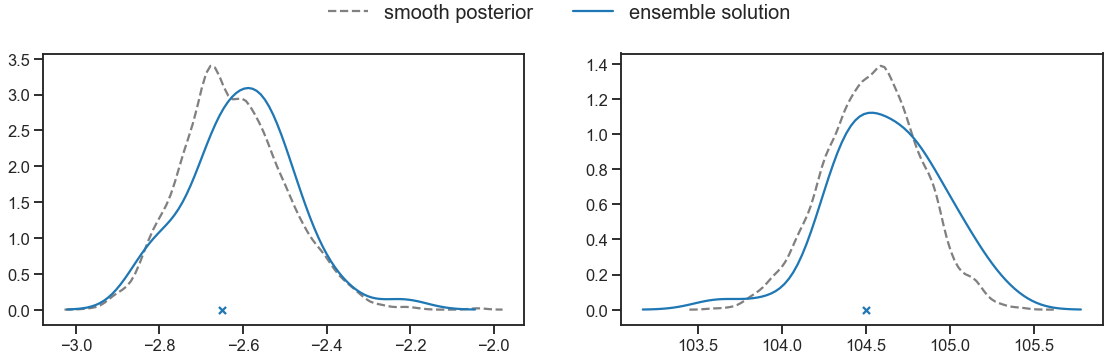

In [24]:
j = 0

fig, axes = plt.subplots(1, p, figsize = (19, 5))

sns.kdeplot(samples_truth_clean[:,j], linestyle = '--', label = 'smooth posterior', ax=axes[j], legend = False, c = 'gray' )
#sns.kdeplot(samples_truth[:,j], label = 'noisy posterior', ax=axes[j], legend = False)
sns.kdeplot(enki_elliptic.Ustar[j], label = 'ensemble solution', ax=axes[j], legend = False)

axes[j].scatter(np.array(enki_elliptic.ustar[j]), np.array(0), marker = "x", s = 50);
#axes[0].set_xlim(-3, 1)

for j in range(1, p):
    sns.kdeplot(samples_truth_clean[:,j], linestyle = '--',ax=axes[j], legend = False, c = 'gray' )
#    sns.kdeplot(samples_truth[:,j], ax=axes[j], legend = False)
    sns.kdeplot(enki_elliptic.Ustar[j], ax=axes[j], legend = False)
    axes[j].scatter(np.array(enki_elliptic.ustar[j]), np.array(0), marker = "x", s = 50);
    
#axes[1].set_xlim(0, 4)

fig.legend(loc='upper center', ncol = 3, borderaxespad=-.2, 
          shadow = True, fancybox = True, prop={'size': 20});

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


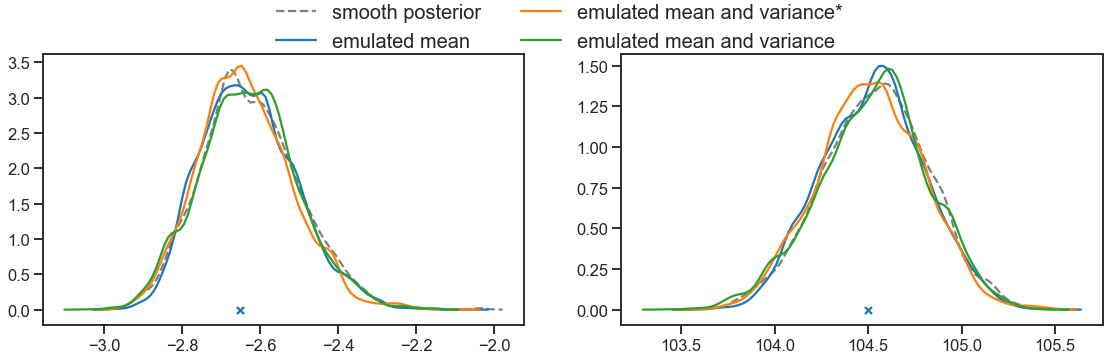

In [25]:
j = 0

fig, axes = plt.subplots(1, p, figsize = (19, 5))

sns.kdeplot(samples_truth_clean[:,j], linestyle = '--', label = 'smooth posterior', ax=axes[j], legend = False, c = 'gray' )
sns.kdeplot(samples_gp_mean[:,j], label = 'emulated mean', ax=axes[j], legend = False)
sns.kdeplot(samples_gp_semi[:,j], label = 'emulated mean and variance*', ax=axes[j], legend = False)
sns.kdeplot(samples_gp_full[:,j], label = 'emulated mean and variance', ax=axes[j], legend = False)

axes[j].scatter(np.array(enki_elliptic.ustar[j]), np.array(0), marker = "x", s = 50);
#axes[0].set_xlim(-3, 1)

for j in range(1, p):
    sns.kdeplot(samples_truth_clean[:,j], linestyle = '--',ax=axes[j], legend = False, c = 'gray' )
    sns.kdeplot(samples_gp_mean[:,j], ax=axes[j], legend = False)
    sns.kdeplot(samples_gp_semi[:,j], ax=axes[j], legend = False)
    sns.kdeplot(samples_gp_full[:,j], ax=axes[j], legend = False)
    axes[j].scatter(np.array(enki_elliptic.ustar[j]), np.array(0), marker = "x", s = 50);
    
#axes[1].set_xlim(0, 4)

fig.legend(loc='upper center', ncol = 2, borderaxespad=-.2, 
          shadow = True, fancybox = True, prop={'size': 20});

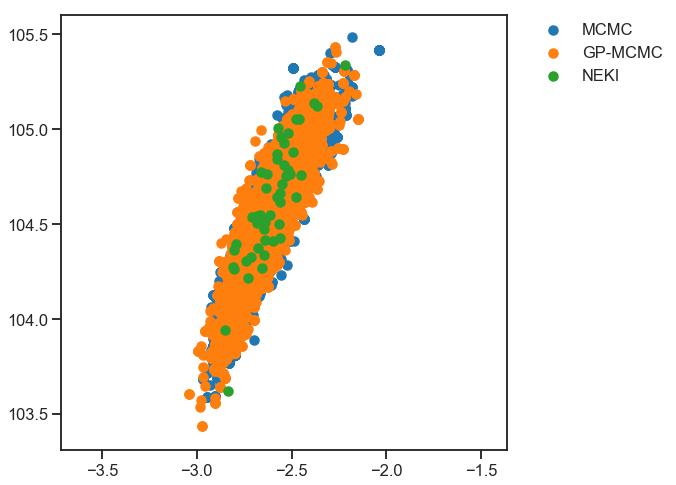

In [26]:
fig, ax = plt.subplots(1,1, figsize = (8, 8));

plt.scatter(samples_truth_clean[:,0], samples_truth_clean[:,1], label = 'MCMC')
plt.scatter(samples_gp_full[:,0], samples_gp_full[:,1], label = 'GP-MCMC')
plt.scatter(enki_elliptic.Uall[-1][0,:], enki_elliptic.Uall[-1][1,:], label = 'NEKI')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.axis('equal');